# YOLO Relay 推理

参考：[ultralytics](https://github.com/ultralytics/ultralytics)

In [1]:
import torch
torch.cuda.empty_cache()

## 测试 YOLO PyTorch 前端


0: 416x640 1 car, 275.3ms
Speed: 320.7ms preprocess, 275.3ms inference, 1217.7ms postprocess per image at shape (1, 3, 416, 640)


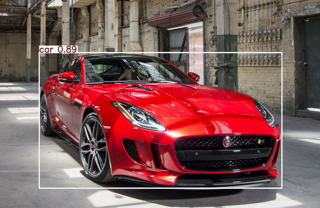

In [2]:
from PIL import Image
import numpy as np
from ultralytics import YOLO

input_path = "images/vehicle-jaguar-f-type-car-red-cars-wallpaper.jpg"
im = Image.open(input_path)
yolo = YOLO("yolo11n.pt")
results = yolo(np.array(im), conf=0.25)
Image.fromarray(results[0].plot()).resize((320, 208))

## YOLO 输入预处理

数据内存的连续性：True
数据内存的连续性(transpose)：False
数据内存的连续性：True


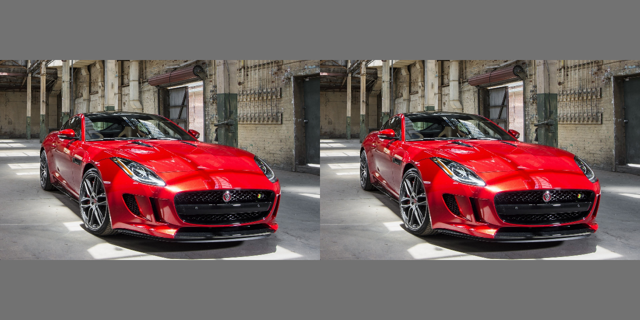

In [3]:
from PIL import Image
import numpy as np
import torch
from ultralytics.data.augment import LetterBox

imgsz = 640, 640
strides = yolo.model.stride
mean = (0,)
std = (255,)

letterbox = LetterBox(new_shape=imgsz, auto=False, scaleFill=False, scaleup=True, stride=32)
origin_image = np.asanyarray(Image.open(input_path))
letterbox_image = letterbox(image=origin_image)
xs = np.stack([letterbox_image - mean])
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = xs.transpose((0, 3, 1, 2))  # BHWC to BCHW, (n, 3, h, w)
print(f"数据内存的连续性(transpose)：{xs.flags["C_CONTIGUOUS"]}")
xs = np.ascontiguousarray(xs)  # contiguous
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = xs.astype("float32") / std # 归一化值域范围为 0.0 - 1.0
Image.fromarray(
    np.concatenate([letterbox_image, (xs[0]*std).astype("uint8").transpose((1, 2, 0))], axis=1)
).resize((640, 320,))

## 测试 YOLO ONNX Relay 前端

导出 ONNX 模型：

In [4]:
yolo.export(format="onnx")

Ultralytics 8.3.58 🚀 Python-3.12.2 torch-2.5.1 CPU (Intel Xeon E5-2678 v3 2.50GHz)

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.46...
ONNX: export success ✅ 1.7s, saved as 'yolo11n.onnx' (10.2 MB)

Export complete (1.9s)
Results saved to /media/pc/data/lxw/ai/tvm-book/doc/topics/other/ultralytics
Predict:         yolo predict task=detect model=yolo11n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.onnx'

前端导入：

In [5]:
import onnx
from tvm import relay

input_name = "images"
onnx_model = onnx.load('yolo11n.onnx')
mod, params = relay.frontend.from_onnx(onnx_model, {input_name: xs.shape}, freeze_params=True)

In [6]:
mod.show()

后处理：

In [7]:
from ultralytics.utils import ops
from ultralytics.engine.results import Results

def postprocess(preds, img, orig_imgs, names, input_path, conf_thres=0.25, iou_thres=0.45,):
    """Post-processes predictions and returns a list of Results objects."""
    preds = ops.non_max_suppression(
        preds,
        conf_thres=conf_thres,
        iou_thres=iou_thres,
        # agnostic=self.args.agnostic_nms,
        # max_det=self.args.max_det,
        # classes=80,
    )

    results = []
    for i, pred in enumerate(preds):
        orig_img = orig_imgs[i]
        pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
        img_path = input_path
        results.append(Results(orig_img, path=img_path, names=names, boxes=pred))
    return results

构建模型：

In [8]:
import tvm

with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
    lib = relay.build(mod, target="llvm", params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(tvm.cpu(0)))

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


运行时推理：

In [9]:
module.run(**{input_name: xs})
num_outputs = module.get_num_outputs()
float_outputs = [module.get_output(k).numpy() for k in range(num_outputs)]
results = postprocess(
    [torch.from_numpy(o) for o in float_outputs], 
    xs, [origin_image], yolo.model.names, 
    input_path, #conf_thres=0.25, iou_thres=0.45,
)
im = Image.fromarray(results[0].plot())
im.size

(1920, 1200)

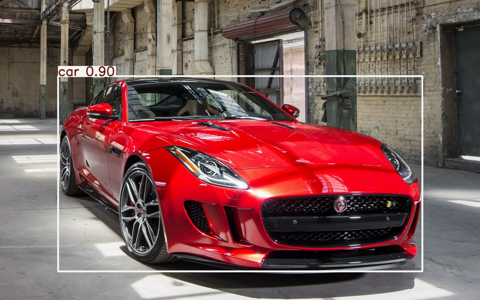

In [10]:
im.resize((480, 300))

## 测试 YOLO TorchScript Relay 前端

导出 torchscript 模型：

In [11]:
yolo.export(format="torchscript")

Ultralytics 8.3.58 🚀 Python-3.12.2 torch-2.5.1 CPU (Intel Xeon E5-2678 v3 2.50GHz)

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

TorchScript: starting export with torch 2.5.1...
TorchScript: export success ✅ 2.2s, saved as 'yolo11n.torchscript' (10.5 MB)

Export complete (2.5s)
Results saved to /media/pc/data/lxw/ai/tvm-book/doc/topics/other/ultralytics
Predict:         yolo predict task=detect model=yolo11n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolo11n.torchscript imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.torchscript'

In [12]:
import torch
from tvm import relay

torch_model = torch.jit.load("yolo11n.torchscript")
mod, params = relay.frontend.from_pytorch(torch_model, [(input_name, xs.shape)])

In [13]:
import tvm
tvm.IRModule.from_expr(mod["main"]).show()

In [14]:
# 构建模型：
with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
    lib = relay.build(mod, target="llvm", params=params)
func = lib[lib.libmod_name]
module = tvm.contrib.graph_executor.GraphModule(func(tvm.cpu(0)))
# 运行时推理：
module.run(**{input_name: xs})
num_outputs = module.get_num_outputs()
float_outputs = [module.get_output(k).numpy() for k in range(num_outputs)]
results = postprocess(
    [torch.from_numpy(o) for o in float_outputs], 
    xs, [origin_image], yolo.model.names, 
    input_path, #conf_thres=0.25, iou_thres=0.45,
)
im = Image.fromarray(results[0].plot())
im.size

(1920, 1200)

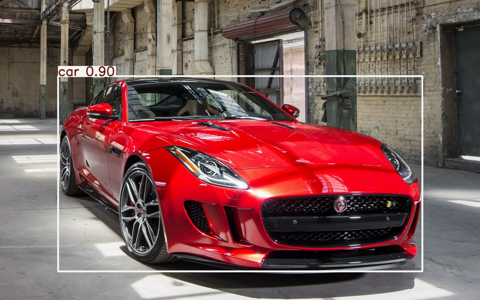

In [15]:
im.resize((480, 300))